In [70]:
import numpy as np
from lattice import lattice_2D
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
from LLGS_simulation import LLGS_Simulation_2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import glob
from numba import njit, prange
import matplotlib.patches as mpatches

In [18]:
Neel = lattice_2D(2,4,4)
Neel.set_position(
    r_a = np.array([1,0]),
    r_b = np.array([0.5,0.5*np.sqrt(3)]),
    r_site = np.array((
    [0.5,np.sqrt(3)/6] #first site
    ,[1,np.sqrt(3)/3] #second site
    ))
)

In [19]:
def initial_Neel(lattice:lattice_2D):
    """
        Initial particles
    """
    N=lattice.N
    sx=np.zeros(N)
    sy=np.zeros(N)
    sz=np.zeros(N)
    for n in range(N):
        if lattice._tag[n,0] == 1:
            sz[n] = 1
        else:
            sz[n] = -1
    spins = np.transpose(np.vstack((sx,sy,sz)))
    spins_normalized = normalize(spins)

    lattice.set_spins(spins_normalized)
    return lattice

In [20]:
initial_Neel(Neel)

<Figure size 640x480 with 0 Axes>

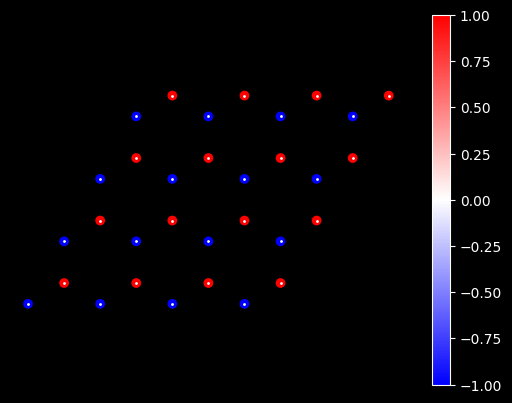

In [21]:
Neel.plot()

In [22]:
Zigzag = lattice_2D(2,4,4)
Zigzag.set_position(
    r_a = np.array([1,0]),
    r_b = np.array([0.5,0.5*np.sqrt(3)]),
    r_site = np.array((
    [0.5,np.sqrt(3)/6] #first site
    ,[1,np.sqrt(3)/3] #second site
    ))
)

In [23]:
def initial_Zigzag(lattice:lattice_2D):
    """
        Initial particles
    """
    N=lattice.N
    sx=np.zeros(N)
    sy=np.zeros(N)
    sz=np.zeros(N)
    for n in range(N):
        if lattice._tag[n,2]%2==0:
            sz[n]=1
        else:
            sz[n]=-1
    spins = np.transpose(np.vstack((sx,sy,sz)))
    spins_normalized = normalize(spins)

    lattice.set_spins(spins_normalized)
    return lattice

In [24]:
initial_Zigzag(Zigzag)

<Figure size 640x480 with 0 Axes>

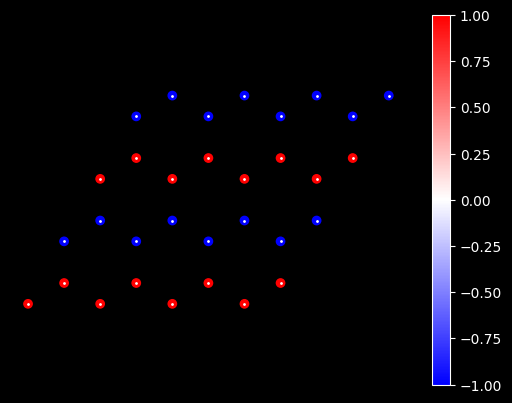

In [25]:
Zigzag.plot()

In [26]:
stripe = lattice_2D(2,4,4)
stripe.set_position(
    r_a = np.array([1,0]),
    r_b = np.array([0.5,0.5*np.sqrt(3)]),
    r_site = np.array((
    [0.5,np.sqrt(3)/6] #first site
    ,[1,np.sqrt(3)/3] #second site
    ))
)

In [27]:
def initial_stripe(lattice:lattice_2D):
    """
        Initial particles
    """
    N=lattice.N
    sx=np.zeros(N)
    sy=np.zeros(N)
    sz=np.zeros(N)
    for n in range(N):
        if (lattice._tag[n,1]+lattice._tag[n,2])%2==0:
            sz[n]=1
        else:
            sz[n]=-1
    spins = np.transpose(np.vstack((sx,sy,sz)))
    spins_normalized = normalize(spins)

    lattice.set_spins(spins_normalized)
    return lattice

In [28]:
initial_stripe(stripe)

<Figure size 640x480 with 0 Axes>

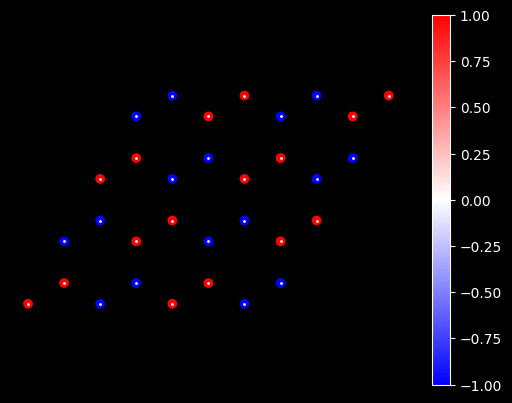

In [29]:
stripe.plot()

In [32]:
tags = Neel._tag.astype(np.int32)

def H_E_AFM_fully_conected(tags,J_1=0,J_2=0,J_3=0):
    N = len(tags[:,0])
    H_E = np.zeros((N,N))

    site = tags[:,0]
    a = tags[:,1]
    b = tags[:,2]

    def is_neighbor(i,j):
        if site[i] != site[j]:
            if a[j] == a[i] and b[j] == b[i]:
                return True
            elif a[j] == a[i]+site[i]-site[j] and b[j] == b[i]:
                return True
            elif a[j] == a[i] and b[j] == b[i]+site[i]-site[j]:
                return True
            else:
                return False        
        else:
            return False
    
    def is_next_nearest_neighbor(i,j):
        if site[i] == site[j]:
            if a[j] == a[i]+1 and b[j] == b[i]:
                return True
            elif a[j] == a[i]-1 and b[j] == b[i]:
                return True
            elif a[j] == a[i] and b[j] == b[i]+1:
                return True
            elif a[j] == a[i] and b[j] == b[i]-1:
                return True
            elif a[j] == a[i]-1 and b[j] == b[i]+1:
                return True
            elif a[j] == a[i]+1 and b[j] == b[i]-1:
                return True
            else:
                return False        
        else:
            return False

    def is_next_next_nearest_neighbor(i,j):
        if site[i] != site[j]:
            if a[j] == a[i]-1 and b[j] == b[i]+1:
                return True
            elif a[j] == a[i]+1 and b[j] == b[i]-1:
                return True
            elif a[j] == a[i]+site[i]-site[j] and b[j] == b[i]+site[i]-site[j]:
                return True
            else:
                return False        
        else:
            return False

    def update_H_E():
        for i in range(N):
            for j in range(N):
                if is_neighbor(i,j) == True:
                    H_E[i,j] = J_1
                elif is_next_nearest_neighbor(i,j) == True:
                    H_E[i,j] = J_2
                elif is_next_next_nearest_neighbor(i,j) == True:
                    H_E[i,j] = J_3
        return

    a_max = np.max(a)
    b_max = np.max(b)
    update_H_E()                    #initial update
    a = np.where(a==a_max,-1,a)
    update_H_E()                    #consider a_max = a_-1
    a = np.where(a==-1,a_max,a)
    b = np.where(b==b_max,-1,b)
    update_H_E()                    #consider b_max = b_-1
    a = np.where(a==a_max,-1,a)     #consider a_max = a_-1 and b_max = b_-1
    update_H_E()


    return H_E

H_E = H_E_AFM_fully_conected(tags,J_1=-32.76,J_2=1.72,J_3=118.96)
print(H_E)

[[  0.   -32.76   1.72 ...   0.     0.   118.96]
 [-32.76   0.   -32.76 ...   0.     0.     0.  ]
 [  1.72 -32.76   0.   ... 118.96   0.     0.  ]
 ...
 [  0.     0.   118.96 ...   0.   -32.76   1.72]
 [  0.     0.     0.   ... -32.76   0.   -32.76]
 [118.96   0.     0.   ...   1.72 -32.76   0.  ]]


In [43]:
def E_Neel(H_E):
    sz = Neel.get_spins()[:,2]
    E_ex = np.dot(sz,np.dot(H_E,sz))
    return E_ex
def E_zigzag(H_E):
    sz = Zigzag.get_spins()[:,2]
    E_ex = np.dot(sz,np.dot(H_E,sz))
    return E_ex
def E_stripe(H_E):
    sz = stripe.get_spins()[:,2]
    E_ex = np.dot(sz,np.dot(H_E,sz))
    return E_ex

In [46]:
print(E_Neel(H_E=H_E))
print(E_zigzag(H_E=H_E))
print(E_stripe(H_E=H_E))

-7944.959999999999
-12578.56
12358.4


In [85]:
def AFM_type(J_2, J_3, J_1=1):
    H_E = H_E_AFM_fully_conected(tags=tags,J_1=J_1,J_2=J_2,J_3=J_3)
    E_N = E_Neel(H_E)
    E_z = E_zigzag(H_E)
    E_s = E_stripe(H_E)
    if E_N < E_s and E_N < E_z:
        return 'Neel'
    elif E_z < E_N and E_z < E_s:
        return 'Zigzag'
    elif E_s < E_N and E_s < E_z:
        return 'stripe'
    else:
        return 'else'

In [86]:
AFM_type(J_1=-32.76,J_2=1.72,J_3=118.96)

'Zigzag'

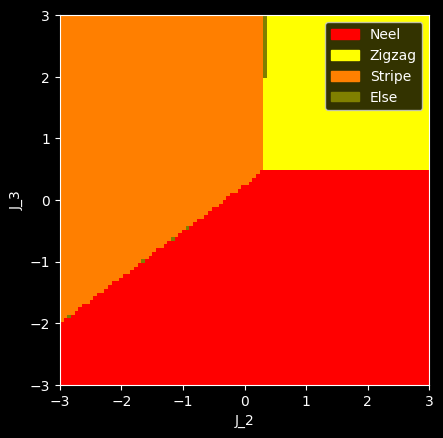

In [103]:
N_grid = 100
J_2 = np.linspace(-3,3,N_grid)
J_3 = np.linspace(-3,3,N_grid)
AFMtype = np.zeros((N_grid,N_grid))
for i in range(N_grid):
    for j in range(N_grid):
        if AFM_type(J_2[i],J_3[j])=='Neel':
            AFMtype[i,j]=1
        elif AFM_type(J_2[i],J_3[j])=='Zigzag':
            AFMtype[i,j]=2
        elif AFM_type(J_2[i],J_3[j])=='stripe':
            AFMtype[i,j]=3
        elif AFM_type(J_2[i],J_3[j])=='else':
            AFMtype[i,j]=4
AFMtype = AFMtype.astype(np.int32)

t = 1 ## alpha value
cmap = {1:[1,0,0,t],2:[1,1,0,t],3:[1,0.5,0,t],4:[0.5,0.5,0,t]}
labels = {1:'Neel',2:'Zigzag',3:'Stripe',4:'Else'}
arrayShow = np.array([[cmap[i] for i in j] for j in AFMtype])
## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.imshow(arrayShow,origin="lower", extent=[-3,3,-3,3])
plt.xlabel('J_2')
plt.ylabel('J_3')
plt.legend(handles=patches)
plt.show()

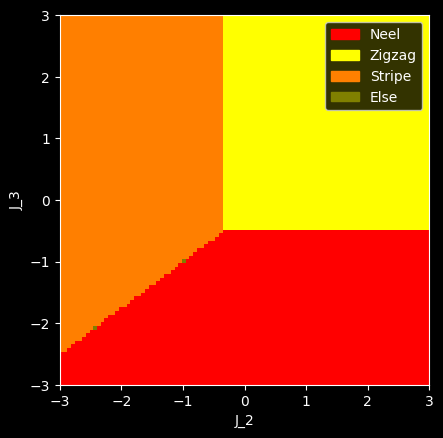

In [104]:
N_grid = 100
J_2 = np.linspace(-3,3,N_grid)
J_3 = np.linspace(-3,3,N_grid)
AFMtype = np.zeros((N_grid,N_grid))
for i in range(N_grid):
    for j in range(N_grid):
        if AFM_type(J_2[i],J_3[j],J_1=-1)=='Neel':
            AFMtype[i,j]=1
        elif AFM_type(J_2[i],J_3[j],J_1=-1)=='Zigzag':
            AFMtype[i,j]=2
        elif AFM_type(J_2[i],J_3[j],J_1=-1)=='stripe':
            AFMtype[i,j]=3
        elif AFM_type(J_2[i],J_3[j],J_1=-1)=='else':
            AFMtype[i,j]=4
AFMtype = AFMtype.astype(np.int32)

t = 1 ## alpha value
cmap = {1:[1,0,0,t],2:[1,1,0,t],3:[1,0.5,0,t],4:[0.5,0.5,0,t]}
labels = {1:'Neel',2:'Zigzag',3:'Stripe',4:'Else'}
arrayShow = np.array([[cmap[i] for i in j] for j in AFMtype])
## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.imshow(arrayShow,origin="lower", extent=[-3,3,-3,3])
plt.xlabel('J_2')
plt.ylabel('J_3')
plt.legend(handles=patches)
plt.show()